<a href="https://colab.research.google.com/github/mBidarra/Software-Engineering/blob/master/mudancaDecubito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import files
import os

# Crie um diretório para salvar as imagens
os.makedirs("test-dorsal", exist_ok=True)

# Faça upload das imagens
uploaded = files.upload()

# Salve as imagens no diretório
for filename in uploaded.keys():
    with open(os.path.join("test-dorsal", filename), "wb") as f:
        f.write(uploaded[filename])
print("Upload concluído. As imagens estão salvas na pasta 'test-dorsal'.")

Saving debucito-dorsal.jpeg to debucito-dorsal (1).jpeg
Upload concluído. As imagens estão salvas na pasta 'test-dorsal'.


In [4]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 43.4 MB/s eta 0:00:00


Imagem debucito-dorsal (1).jpeg: Posição não identificada.


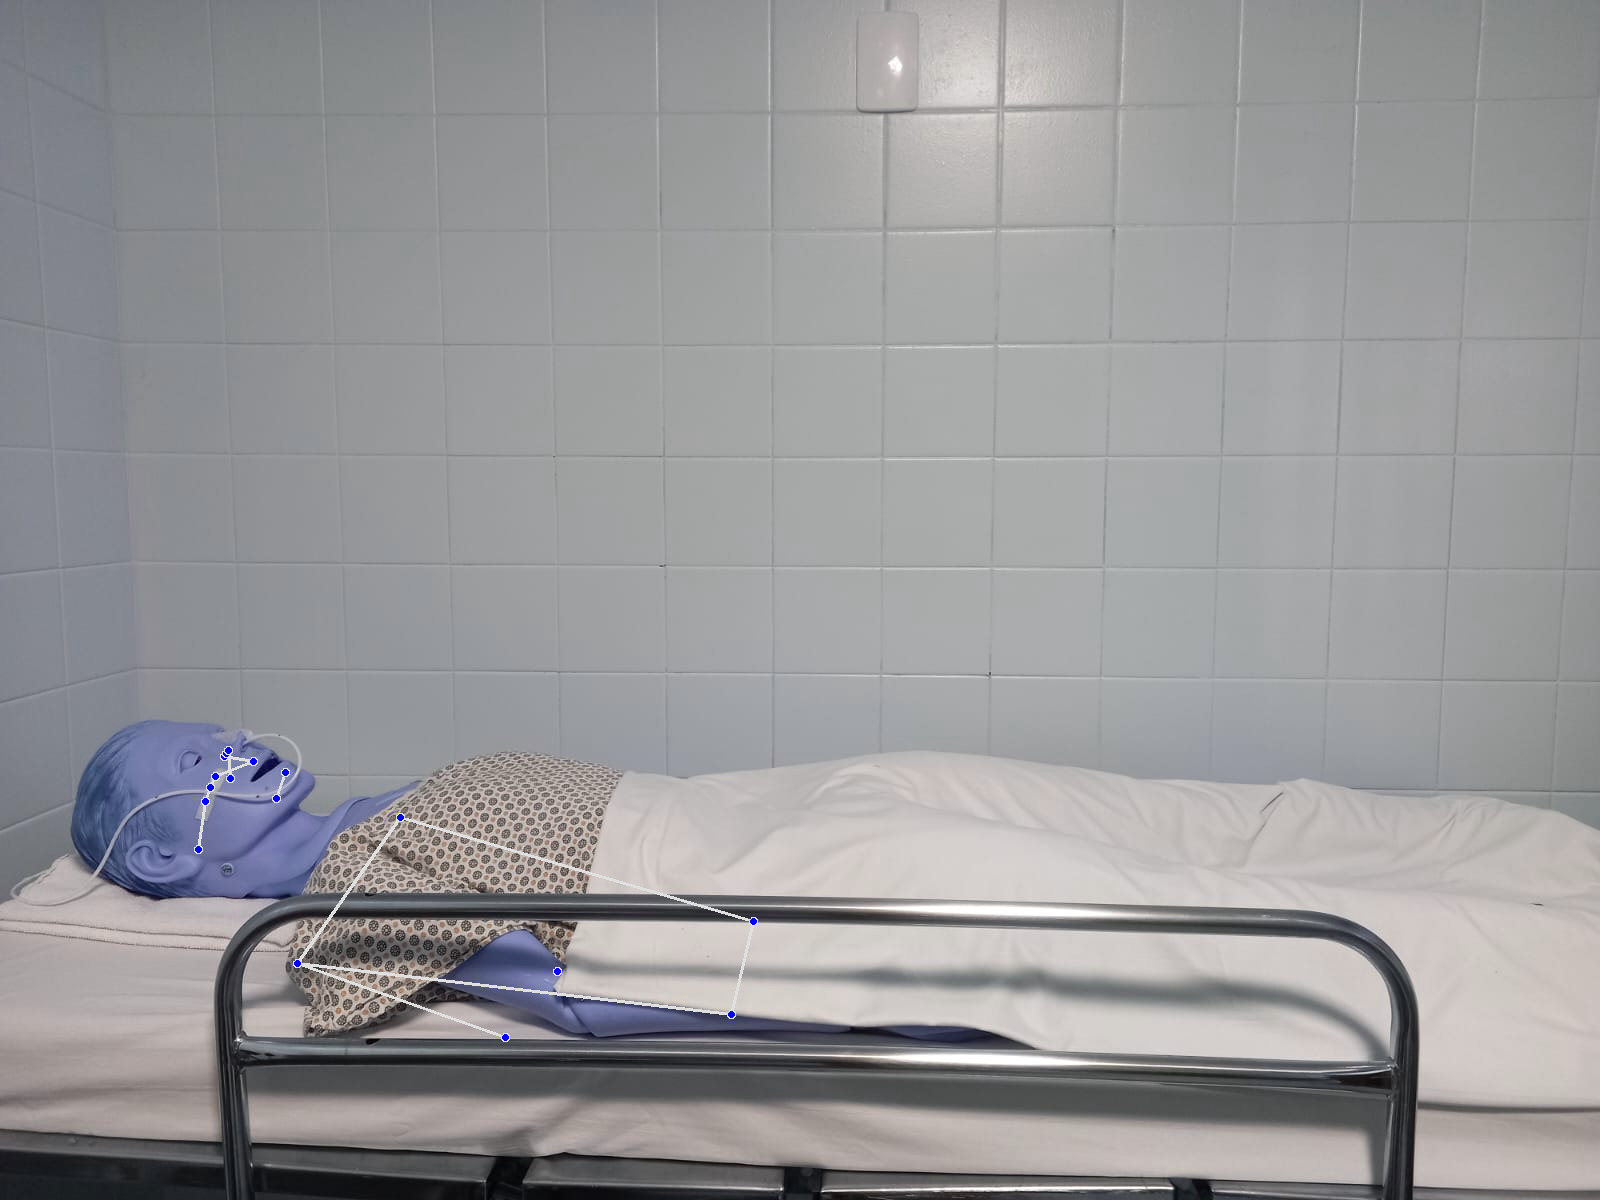


Contagem de posições:
Decúbito Dorsal: 0
Decúbito Lateral Direito: 0
Decúbito Lateral Esquerdo: 0


In [29]:
import cv2
import mediapipe as mp
import os
from google.colab.patches import cv2_imshow

# Inicializar Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

# Variáveis para contar as posições
count_dorsal = 0
count_lateral_direito = 0
count_lateral_esquerdo = 0

# Pasta com as imagens
image_folder = "test-dorsal"

# Definir limiares
#y_threshold = 0.05  # Para diferenças verticais
#x_threshold = 0.05  # Para diferenças horizontais
y_threshold = 0.07  # Aumentamos o limiar para diferenças verticais
x_symmetry_threshold = 0.15  # Aumentamos o limiar para simetria horizontal
x_symmetry_threshold = 0.1  # Para simetria horizontal

# Funções auxiliares
def is_level(point1, point2, threshold=y_threshold):
    return abs(point1.y - point2.y) < threshold

def is_aligned_horizontally(point1, point2_or_x, threshold=x_threshold):
    x1 = point1.x
    if isinstance(point2_or_x, float):
        x2 = point2_or_x
    else:
        x2 = point2_or_x.x
    return abs(x1 - x2) < threshold

def is_aligned_vertically(point1, point2, threshold=y_threshold):
    return abs(point1.y - point2.y) < threshold

# Verificar simetria horizontal (para decúbito dorsal)
def is_symmetrical(points_left, points_right, center_x, threshold=x_symmetry_threshold):
    symmetrical = True
    for p_left, p_right in zip(points_left, points_right):
        left_dist = abs(p_left.x - center_x)
        right_dist = abs(p_right.x - center_x)
        if abs(left_dist - right_dist) > threshold:
            symmetrical = False
            break
    return symmetrical

# Processar cada imagem
for image_file in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_file)

    # Carregar imagem
    image = cv2.imread(image_path)
    if image is None:
        print(f"Não foi possível carregar a imagem {image_file}.")
        continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detectar poses
    results = pose.process(image_rgb)

    # Verificar se alguma pose foi detectada
    if not results.pose_landmarks:
        print(f"Nenhuma pose detectada na imagem {image_file}.")
        continue

    # Obter landmarks relevantes
    landmarks = results.pose_landmarks.landmark

    # Landmarks dos ombros, quadris, cotovelos, joelhos, tornozelos, nariz, olhos e orelhas
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
    left_elbow = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW]
    right_elbow = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW]
    left_wrist = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]
    right_wrist = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST]
    left_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
    right_knee = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE]
    left_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]
    right_ankle = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE]
    nose = landmarks[mp_pose.PoseLandmark.NOSE]
    left_eye = landmarks[mp_pose.PoseLandmark.LEFT_EYE]
    right_eye = landmarks[mp_pose.PoseLandmark.RIGHT_EYE]
    left_ear = landmarks[mp_pose.PoseLandmark.LEFT_EAR]
    right_ear = landmarks[mp_pose.PoseLandmark.RIGHT_EAR]

    # Centro do corpo no eixo x (horizontal)
    body_center_x = (left_shoulder.x + right_shoulder.x + left_hip.x + right_hip.x) / 4

    # Listas de pontos para verificar simetria
    points_left = [left_shoulder, left_elbow, left_wrist, left_hip, left_knee, left_ankle]
    points_right = [right_shoulder, right_elbow, right_wrist, right_hip, right_knee, right_ankle]

    # Verificar alinhamento vertical e horizontal dos ombros e quadris
    shoulders_level = is_level(left_shoulder, right_shoulder)
    hips_level = is_level(left_hip, right_hip)
    shoulders_aligned = is_aligned_horizontally(left_shoulder, right_shoulder)
    hips_aligned = is_aligned_horizontally(left_hip, right_hip)

    # 1ª Validação para decúbito dorsal (como antes)
    symmetrical = is_symmetrical(points_left, points_right, body_center_x)
    nose_centered = abs(nose.x - body_center_x) < x_symmetry_threshold

    # Primeira Validação: Ombros e Quadris
    if shoulders_level and hips_level and symmetrical and nose_centered:
        print(f"Imagem {image_file}: decubito-dorsal (1ª validação)")
        count_dorsal += 1

    # 2ª Validação para decúbito dorsal, usando olhos
    elif (
        is_level(left_eye, right_eye, threshold=y_threshold) and
        abs((left_eye.x + right_eye.x)/2 - body_center_x) < x_symmetry_threshold and
        abs(nose.y - left_eye.y) < y_threshold and
        abs(nose.y - right_eye.y) < y_threshold
    ):
        print(f"Imagem {image_file}: decubito-dorsal (2ª validação - olhos)")
        count_dorsal += 1

    # 3ª Validação para decúbito dorsal, usando orelhas
    elif (
        is_level(left_ear, right_ear, threshold=y_threshold) and
        abs(left_ear.x - body_center_x) - abs(right_ear.x - body_center_x) < x_symmetry_threshold and
        abs(left_ear.y - nose.y) < y_threshold and
        abs(right_ear.y - nose.y) < y_threshold
    ):
        print(f"Imagem {image_file}: decubito-dorsal (3ª validação - orelhas)")
        count_dorsal += 1

    # Condições para decúbito lateral direito
    elif (
        shoulders_aligned and hips_aligned and
        left_shoulder.y < right_shoulder.y and
        left_hip.y < right_hip.y
    ):
        print(f"Imagem {image_file}: decubito-lateral-direito")
        count_lateral_direito += 1

    # Condições para decúbito lateral esquerdo
    elif (
        shoulders_aligned and hips_aligned and
        right_shoulder.y < left_shoulder.y and
        right_hip.y < left_hip.y
    ):
        print(f"Imagem {image_file}: decubito-lateral-esquerdo")
        count_lateral_esquerdo += 1

    else:
        print(f"Imagem {image_file}: Posição não identificada.")


    # Visualizar a imagem com landmarks
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

# Mostrar a contagem de cada posição
print("\nContagem de posições:")
print(f"Decúbito Dorsal: {count_dorsal}")
print(f"Decúbito Lateral Direito: {count_lateral_direito}")
print(f"Decúbito Lateral Esquerdo: {count_lateral_esquerdo}")
